https://kawine.github.io/blog/nlp/2019/06/21/word-analogies.html

# Introduction to NLP Fundamentals in TensorFlow


NLP has the goal of deriving inforamtion out of natural language (could be sequences text or speech).

Anothre common term for NLP problems is sequence to sequence problems (seq2seq)

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-72da265d-519c-5208-2d37-1aafab57f7e7)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-02-25 20:55:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-25 20:55:12 (55.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset


The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster.)


See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-02-25 20:55:17--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.008s  

2022-02-25 20:55:18 (70.3 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset


To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

Another way to do this is to use pandas...

Or using tensorflow load text : https://www.tensorflow.org/tutorials/load_data/text

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the text datframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### tensorflow imbalanced dataset

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Visualize some random trainig examples
import random
random_index = random.randint(0,len(train_df)-5) # create random indexex not higher than total number of samples
for row in train_df_shuffled[["text","target"]][random_index:random_index + 5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target> 0 else "(not real  disaster)")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0 (not real  disaster)
Text:
I think this is my plan for retirement. Check out the weapons of mass instruction! #bookmobile #libraries #reading http://t.co/L2NMywrmq2

----

Target: 0 (not real  disaster)
Text:
I feel like death

----

Target: 1 (real disaster)
Text:
Tunisia beach massacre linked to March terror attack on museum http://t.co/kuRqLxFiHL

----

Target: 1 (real disaster)
Text:
#flood #disaster Bengal floods: CM Mamata Banerjee blames DVC BJP claims state failed to use ... - Economic T... http://t.co/BOZlwr716Z

----

Target: 1 (real disaster)
Text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/C9t2F6DLtM

----



### Split data into training and validation sets



In [11]:
from sklearn.model_selection import train_test_split


In [12]:
# Use  train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1, # use 10% of training data for valid 
                                                                            random_state =42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len (val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

Word embeddings tensorflow hub : https://www.tensorflow.org/text/guide/word_embeddings

When dealing with a text problem, one of the first things we have to do before build a model is to conver the text to nubmers

There are a few ways to this, namely: 
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector canbe defined and this embedding can be learned)

### TExt vectoriazation (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens = None, #how many words in the vocabulary (automatically add <oov> out of vocabulary)
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams = None,  # Create groups of n-words
                                    output_mode = "int", # how to map tokens to numbers
                                    output_sequence_length = None) # how long do we want the sequences to be?
                                    # pad_to_max_tokens = False)

In [17]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [18]:
# Find the average number of tokens (words) in the training tweets

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
# Setup text vectorization vairiables

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)


In [20]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a sample sentence and tokenize it

sample_sentence  = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence} \
      \n \n Vectorized version: ")

text_vectorizer([random_sentence])

Original text: 
 Setting Up An Emergency Fund In 3 Easy Steps: You never know when a surprise expense will pop up. So work up t... http://t.co/Iz17kLelZC       
 
 Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1257,   27,   39,   73, 2984,    4,  118, 2481, 1966,   12,  192,
         106,   45,    3, 1958]])>

In [23]:
# Get the unique words in the vocabulary

words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 Most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 Most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [24]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

### Creating an Embedding uisng an Embedding Layer


To make our embedding, we're going to use TensorFlow's  embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` =  the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, # input shape
                             output_dim = 128,
                             embeddings_initializer = 'uniform',
                             input_length = max_length,
                             name = "embedding_1") # how long is each input

embedding


In [26]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence}\
      \n\nEmbedded version:")

# Embed the ranodm sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 So yeah splatoon is still lots of fun and default splattershot jr is still the only weapon layout I'm good at      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 3.3413362e-02,  4.6105195e-02,  1.8721595e-03, ...,
          1.9704703e-02,  8.6333528e-03, -5.9224665e-05],
        [ 3.0171275e-03, -3.8584113e-02,  2.0322468e-02, ...,
         -1.2109052e-02, -2.2675836e-02,  2.8618876e-02],
        [-4.8103988e-02,  1.7652716e-02, -2.9177606e-02, ...,
         -3.7939262e-02, -2.2446478e-02,  3.4964267e-02],
        ...,
        [-2.6604224e-02, -1.7241038e-02, -7.4958205e-03, ...,
         -4.7373332e-02,  3.6944810e-02, -2.4201656e-02],
        [-4.5089722e-02,  3.9605666e-02,  4.7243610e-03, ...,
         -2.4947155e-02, -2.9503262e-02, -2.5078489e-02],
        [ 3.6365476e-02,  3.0388776e-02, -2.8587496e-02, ...,
          1.5382793e-02,  3.4983683e-02, -3.7429444e-03]]], dtype=float32)>

In [27]:
# Check out a single token's embedding 
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 3.3413362e-02,  4.6105195e-02,  1.8721595e-03, -3.3571027e-02,
        -2.3647582e-02, -8.2237720e-03,  7.8751929e-03, -4.3839443e-02,
        -4.6477497e-02,  1.7331067e-02,  2.6176360e-02,  4.6005737e-02,
        -3.2151245e-02, -1.3600886e-02,  3.7888240e-02,  1.5082683e-02,
         1.3613138e-02,  3.0493889e-02,  2.0091381e-02,  1.1219334e-02,
         1.2549970e-02, -2.8476048e-02,  3.1219210e-02,  1.3504896e-02,
         1.7446306e-02, -8.6900592e-03,  2.1342579e-02,  4.8474137e-02,
        -4.3080103e-02, -4.0061951e-02, -3.0633569e-02,  3.1188253e-02,
         4.3186728e-02, -2.6940815e-03, -9.2571974e-03, -4.2620923e-02,
         1.9875836e-02, -2.3241891e-02,  3.2388281e-02,  1.8721111e-03,
         7.6254383e-03,  6.1762929e-03, -6.6994801e-03,  3.6865581e-02,
        -4.3206550e-02,  4.2481486e-02,  1.1776112e-02,  4.1530941e-02,
         2.3513343e-02,  8.3544627e-03,  2.0430628e-02,  4.9219020e-03,
        -4.3296

## Modeling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start builidng a series of modeling experiments.

Start from the baseline and move on..

Sckilearn ML map : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html


* Model 0: Naive Bayes (baseline), this is from Sklearn ML map
* Mdoel 1: Feed-foraward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Mdoel 6: TensorFlow Hub Pretrained Feature Extraction (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

What are the standard steps?

* Create a model 
* Build a model
* Fit a model
* Evaluate a model
*


### Model 0: Getting a baseline

As with all ML modeling experiments, its important to create a baseline model so we've got a benchmark for future experiments to build upon.

To create baseline, use Sklearn's Multimnomial Naive Bayes using the TF-IDF formula to convert words to numbers

> **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using dL to see if we can imporve upon them

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                     ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences,val_labels)

print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [31]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

## Creating an evaluation function for model experiments 

We could evaluate all of our model's predictions with different metrics every time, this will be cumbersome and could easily be fixed

Create one to compare our model's predictinos with the truth labels using the following metrics:

* Accuracy
* Precision
* Recall
* F1-score


For a deep overview of many different methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [32]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true,y_pred)* 100

  # Calculate model precision, recall, and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average = "weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results

In [33]:
# Get baseline results
baseline_results = calculate_results(y_true =val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [34]:
# Create a tensorboard callback( need to create a new one for each model)

from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"



### Model 1 : Funtinoal API

In [35]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype = "string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
#  ValueError: `logits` and `labels` must have the same shape, received ((None, 15, 1) vs (None,)).
outputs = layers.Dense(1, activation = "sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs,outputs,name = "model_1_dense")


In [36]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [37]:
# Compile model
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [38]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220225-205527
Epoch 1/5
215/215 [==============================] - 10s 14ms/step - loss: 0.6112 - accuracy: 0.6908 - val_loss: 0.5339 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4414 - accuracy: 0.8209 - val_loss: 0.4706 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3464 - accuracy: 0.8629 - val_loss: 0.4656 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2835 - accuracy: 0.8918 - val_loss: 0.4639 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2375 - accuracy: 0.9111 - val_loss: 0.4835 - val_accuracy: 0.7848


In [39]:
# Check the results
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 7ms/step - loss: 0.4835 - accuracy: 0.7848


[0.48345646262168884, 0.7847769260406494]

In [40]:
# Make some predictions and evaluate them
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [41]:
model_1_pred_probs[0]

array([0.35407022], dtype=float32)

In [42]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [43]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.4776902887139,
 'f1': 0.7814477888250547,
 'precision': 0.7904782347685264,
 'recall': 0.7847769028871391}

In [44]:
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
max_vocab_length

10000

In [47]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [48]:
# Get the weight metrics of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's ee how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

TensorFlow also have word embedding guide : https://www.tensorflow.org/text/guide/word_embeddings


Word2Vec Article : https://databreak.netlify.app/2019-04-25-Illustrated_word2vec/

In [49]:
embed_weights

array([[ 0.00201448, -0.04095063, -0.06490409, ..., -0.04115363,
         0.01753058, -0.0231281 ],
       [ 0.00232872, -0.04810758,  0.00467093, ..., -0.0287883 ,
        -0.00364972, -0.05150971],
       [ 0.05878179,  0.00988497, -0.04906269, ..., -0.0087901 ,
         0.01472912, -0.02403815],
       ...,
       [-0.03759452, -0.04614199,  0.01026635, ..., -0.01068492,
         0.01367924,  0.00346635],
       [ 0.03875557,  0.00842984, -0.01968233, ..., -0.01883762,
         0.00702652, -0.07498974],
       [ 0.02607945, -0.06231895, -0.01578006, ..., -0.04426548,
        -0.10188453, -0.0692745 ]], dtype=float32)

In [50]:
# Create embedding files (from TensorFlow word embedding)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [51]:
# Download files to upload to projector


try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural networks is to use the representation of a previous input to aid the representation of a later input.

What internals of a recurrent neural network see the following:
- MIT's sequence modeling lecture: https://youtube.com/watch?v=SEnXr6v2ifU&feature=youtu.be

- Chirs Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

- Andrej Karpathy's the unreasonable effectiveness of recurrent neural network:http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long shor term memory (one of the most popular LSTM cells)

The structure of an RNN typically looks like this

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probabilty)
```

TensorFlow LSTM : https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM


In [52]:
# Create an LSTM model

from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units = 64,return_sequences=True)(x) # When stacking RNN cells together, we need to set return_sequences = True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64,activation = "relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name = "model_2_LSTM")

In [53]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [54]:
# Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [55]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220225-205554
Epoch 1/5
215/215 [==============================] - 12s 18ms/step - loss: 0.2135 - accuracy: 0.9231 - val_loss: 0.5893 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1553 - accuracy: 0.9412 - val_loss: 0.7492 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1275 - accuracy: 0.9502 - val_loss: 0.6077 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1008 - accuracy: 0.9619 - val_loss: 0.7678 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0845 - accuracy: 0.9679 - val_loss: 0.8119 - val_accuracy: 0.7743


In [56]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[9.6079744e-02],
       [8.7169576e-01],
       [9.9963343e-01],
       [5.8200341e-02],
       [6.1397965e-04],
       [9.9426299e-01],
       [8.1445688e-01],
       [9.9979872e-01],
       [9.9960738e-01],
       [3.1116429e-01]], dtype=float32)

In [57]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [59]:
# Calculate model_2 results

model_2_results = calculate_results(val_labels,
                                    model_2_preds)
model_2_results

{'accuracy': 77.42782152230971,
 'f1': 0.7725974162749719,
 'precision': 0.7752857985262857,
 'recall': 0.7742782152230971}

In [60]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3 : GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

TensorFlow GRU : https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

WikiPedia : https://en.wikipedia.org/wiki/Gated_recurrent_unit

Simeon Kosatadinov GRU : https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be


In [61]:
# Build an RNN using the GRU cell

from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)


# print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x) # If we want to stack RNN layers on top of each other, return sequences = True !!!!
# print(x.shape)
# x = layers.LSTM(42,return_sequences = True)(x)
# print(x.shape)
# x = layers.GRU(99)(x)
# print(x.shape)
# x = layers.Dense(64, activation ="relu")(x)
# print(x.shape)
# x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, activation ="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs,name = "model_3_GRU")

In [62]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [63]:
# Compile the model
model_3.compile(loss = "binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [64]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220225-205620
Epoch 1/5
215/215 [==============================] - 5s 10ms/step - loss: 0.1611 - accuracy: 0.9367 - val_loss: 0.7416 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0850 - accuracy: 0.9677 - val_loss: 0.8399 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0680 - accuracy: 0.9721 - val_loss: 0.9839 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0566 - accuracy: 0.9764 - val_loss: 1.1108 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0631 - accuracy: 0.9718 - val_loss: 1.3446 - val_accuracy: 0.7782


In [65]:
# Make some predictions with GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[2.0816373e-03],
       [8.1774247e-01],
       [9.9986911e-01],
       [6.9826141e-02],
       [4.2823278e-05],
       [9.9968350e-01],
       [9.6789038e-01],
       [9.9994254e-01],
       [9.9991822e-01],
       [7.6236939e-01]], dtype=float32)

In [66]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [67]:
# Calculate model 3 results

model_3_results = calculate_results(val_labels,
                                    model_3_preds)
model_3_results

{'accuracy': 77.82152230971128,
 'f1': 0.7763875633348853,
 'precision': 0.7796479981380524,
 'recall': 0.7782152230971129}

### Model 4: Bidirectional RNN

TensorFlow Bidirectional: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

Normal RNN's go from left to right (just as we read English), however, a bidireictional RNN combines right to left and left to right

In [68]:
# Build a bidirectional layer

from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x) # can use any RNN cell 
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1,activation = "sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs,name = "model_4_bidirectional")

In [69]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [70]:
# Compile model
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [71]:
# Fit the model
model_4.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences,val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220225-205635
Epoch 1/5
215/215 [==============================] - 12s 22ms/step - loss: 0.0979 - accuracy: 0.9672 - val_loss: 1.1350 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0504 - accuracy: 0.9758 - val_loss: 1.4330 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0497 - accuracy: 0.9759 - val_loss: 1.3513 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0422 - accuracy: 0.9785 - val_loss: 1.4286 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0402 - accuracy: 0.9787 - val_loss: 1.5583 - val_accuracy: 0.7598


In [72]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[8.4916532e-01],
       [8.2245183e-01],
       [9.9993169e-01],
       [3.0665362e-01],
       [4.9139676e-06],
       [9.9994338e-01],
       [9.8337847e-01],
       [9.9998629e-01],
       [9.9997258e-01],
       [9.9752671e-01]], dtype=float32)

In [73]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [74]:
# Calculate the results of model 4
model_4_results = calculate_results(val_labels,model_2_preds)
model_4_results

{'accuracy': 77.42782152230971,
 'f1': 0.7725974162749719,
 'precision': 0.7752857985262857,
 'recall': 0.7742782152230971}

In [75]:
model_3_results

{'accuracy': 77.82152230971128,
 'f1': 0.7763875633348853,
 'precision': 0.7796479981380524,
 'recall': 0.7782152230971129}

## Convolutional Neural Networks for Text (and other types of sequences)

We've use CNNs for images but images are typically 2D (height x width).. however, our text data is 1D.

Previously Conv2D was used for image data
but we're going to use Conv1D

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs(text) -> Tokenziation -> Embedding -> Layers (typically Conv1D + pooling) -> Outputs (class probabilites)
```


### Model 5: Conv1D


For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)

* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=With%20%22SAME%22%20padding%2C%20if,only%20uses%20valid%20input%20data.

* Activation see: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#:~:text=0%2C%20inf%5D.-,ReLU,)%2C%20but%20with%20better%20performance.

In [87]:
# Test our embedding layer, Conv1D layer amd max pooling

embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters = 64,
                        kernel_size =5,
                        strides = 1, # default
                        activation = "relu",
                        padding = "same") # default = "valid", the output is smaller than the input shape, "same" means output shape is same as input
conv_1d_ouput = conv_1d(embedding_test) # pass test embedding through conv1d layer

max_pool = layers.GlobalMaxPool1D()
max_pool_layer = max_pool(conv_1d_ouput) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_ouput.shape, max_pool_layer.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [95]:
# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,),dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5,
                  strides = 1,
                  activation = "relu",
                  padding = "valid")(x)

x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation ="relu")(x)
outputs = layers.Dense(1,activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs,outputs,name = "model_5_Conv1D")

In [96]:
# Compile Conv1D
model_5.compile(loss ="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [98]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_13 (Conv1D)          (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [99]:
# Fit the model
model_5.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences,val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220225-211330
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1258 - accuracy: 0.9580 - val_loss: 0.8799 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0762 - accuracy: 0.9726 - val_loss: 1.0283 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0608 - accuracy: 0.9750 - val_loss: 1.1627 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0546 - accuracy: 0.9772 - val_loss: 1.2652 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0513 - accuracy: 0.9783 - val_loss: 1.2156 - val_accuracy: 0.7559


In [100]:
# Make predictions
model_5_pred_probs = model_5.predict(val_sentences)

In [101]:
# Convert model_5 pred probs to pred
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [103]:
# Evaluate model 5 predictions
model_5_results = calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 75.59055118110236,
 'f1': 0.7557868020082416,
 'precision': 0.7557099099399044,
 'recall': 0.7559055118110236}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Huggingface Transformers - Pretrained model site : https://huggingface.co/docs/transformers/index

Universal Sentence Encoder : https://tfhub.dev/google/collections/universal-sentence-encoder/1
> See how USE created : https://arxiv.org/abs/1803.11175


Going to use universal sentence encoder for trial



In [104]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When we call the universal sentence encoder, it converts into numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157032  0.02485909  0.02878048 -0.01271501  0.03971539  0.0882776
  0.02680985  0.05589837 -0.0106873  -0.00597291  0.00639325 -0.0181952
  0.00030816  0.09105889  0.05874643 -0.03180627  0.01512473 -0.05162929
  0.00991365 -0.06865346 -0.04209305  0.02678981  0.03011008  0.00321067
 -0.0033797  -0.04787361  0.02266722 -0.00985925 -0.04063613 -0.0129209
 -0.04666385  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014443
  0.02871508  0.04947681 -0.00633976 -0.08960193  0.02807116 -0.00808363
 -0.01360604  0.0599865  -0.10361787 -0.05195372  0.00232956 -0.02332528
 -0.03758106  0.03327731], shape=(50,), dtype=float32)


In [107]:
embed_samples[0].shape

TensorShape([512])

In [108]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = "string",
                                        trainable = False,
                                        name = "USE")

In [119]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation ="relu"),
                               layers.Dense(1,activation = "sigmoid")
],name = "model_6_USE")

# Compile 
model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [120]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [121]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220225-213921
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.5118 - accuracy: 0.7832 - val_loss: 0.4478 - val_accuracy: 0.8110
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4150 - accuracy: 0.8170 - val_loss: 0.4378 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4006 - accuracy: 0.8231 - val_loss: 0.4324 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3925 - accuracy: 0.8256 - val_loss: 0.4281 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3848 - accuracy: 0.8317 - val_loss: 0.4231 - val_accuracy: 0.8189


In [122]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)

In [123]:
# Convert to pred
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [124]:
# Calculate results
model_6_results = calculate_results(val_labels,model_6_preds)
model_6_results

# If we don't have another Dense layer it would have worse results than baseline model
# {'accuracy': 78.74015748031496,
#  'f1': 0.7862340407224946,
#  'precision': 0.7878968015414602,
#  'recall': 0.7874015748031497}

{'accuracy': 81.88976377952756,
 'f1': 0.817984880977007,
 'precision': 0.8196605460013572,
 'recall': 0.8188976377952756}

In [125]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 7: TF Hub pretrained USE but with 10% of training data

Transfer learning really helps when we don't have a large dataset.

To see how model performs on a smaller dataset, let's replicate model_6 except we'll train it with 10% of data

In [129]:
# Create subsets of 10% of the training dtaa

# train_10_percent = train_df_shuffled[["text","target"]].sample(frac = 0.1,random_state = 42)

# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

In [136]:
# Making a better dataset split (no data leakage)

train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [143]:
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

To recrate a model same as a previous model we've created we can use the `tf.keras.models.clone_model()` : https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [130]:
# Build model same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Get a summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [148]:
# Fit the 10% of dataset
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs =5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220225-220333
Epoch 1/5
22/22 [==============================] - 1s 32ms/step - loss: 0.3509 - accuracy: 0.8584 - val_loss: 0.4170 - val_accuracy: 0.8189
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.3384 - accuracy: 0.8584 - val_loss: 0.4242 - val_accuracy: 0.8097
Epoch 3/5
22/22 [==============================] - 1s 30ms/step - loss: 0.3250 - accuracy: 0.8701 - val_loss: 0.4343 - val_accuracy: 0.8045
Epoch 4/5
22/22 [==============================] - 1s 30ms/step - loss: 0.3146 - accuracy: 0.8701 - val_loss: 0.4379 - val_accuracy: 0.7953
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.3066 - accuracy: 0.8803 - val_loss: 0.4462 - val_accuracy: 0.7900


In [149]:
# Predictions
model_7_pred_probs = model_7.predict(val_sentences)

In [150]:
# Convert to pred
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

In [151]:
# Evaluate model 7
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

# With leakage dataset
# {'accuracy': 82.54593175853019,
#  'f1': 0.8252544287718366,
#  'precision': 0.8252816543290777,
#  'recall': 0.8254593175853019}

{'accuracy': 79.00262467191601,
 'f1': 0.7886741430048517,
 'precision': 0.7909267110841915,
 'recall': 0.7900262467191601}

> Why model 7 has better results than model 6??

train_sentences_10_percent has some of the validation sentences because
train_sentences were shuffled and then selected separate to val sentence
However, train_sentences_10_percent was selected from all of the train_df sentences

> **Note:** Be very careful when creating training/val/test splits that we don't leak data across the datasets, otherwise our dmoel evaluation mterics will wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same mdoel trained on 100% of data trus our gut and go back through to find where the error may life)

## Comparing the performance of each of our models



In [157]:
# Combine model results into DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_GRU": model_3_results,
                                  "4_Bidirectional": model_4_results,
                                  "5_Conv1D": model_5_results,
                                  "6_USE":model_6_results,
                                  "7_10%_USE": model_7_results})
all_model_results = all_model_results.transpose()

In [158]:
# Reduce accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

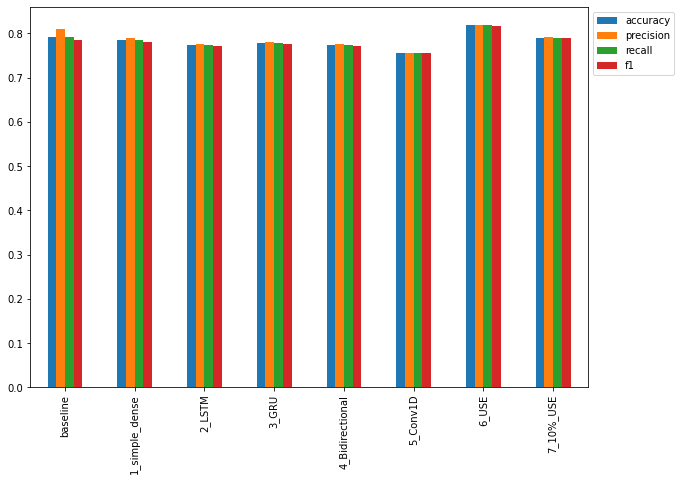

In [159]:
# Plot and compare all of the model results

all_model_results.plot(kind = "bar",figsize = (10,7)).legend(bbox_to_anchor = (1.0,1.0))

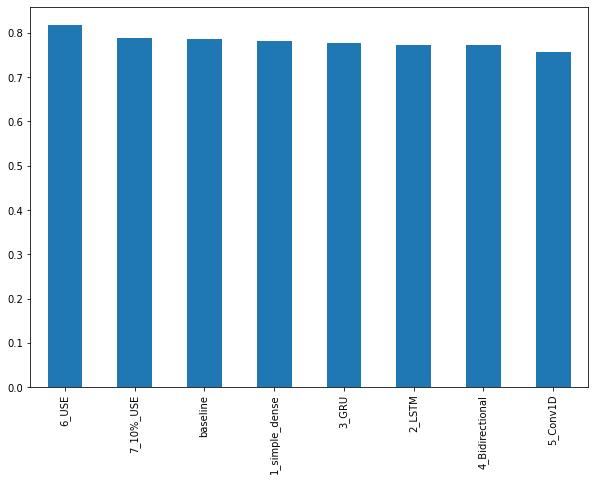

In [160]:
# Sort model results by f1-score
all_model_results.sort_values("f1",ascending = False)["f1"].plot(kind = "bar",figsize = (10,7))

## Uploading our models to TenosrBoard.dev

In [161]:
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modeling Experiments ZTM "\
  --description "Comparing Multiple different types of model on Kaggle Tweets"\
  --one_shot # exit the uploader once uploading is finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=yP4afkxmVpLULSEQHhBcWrLj2khUXO&prompt=consent&access_type=offline

In [162]:
!tensorboard dev list

https://tensorboard.dev/experiment/ksVyJJ52QOq8k0JqNOBakw/
	Name                 NLP Modeling Experiments ZTM 
	Description          Comparing Multiple different types of model on Kaggle Tweets
	Id                   ksVyJJ52QOq8k0JqNOBakw
	Created              2022-02-25 22:14:25 (1 minute ago)
	Updated              2022-02-25 22:14:35 (1 minute ago)
	Runs                 20
	Tags                 5
	Scalars              300
	Tensor bytes         0
	Binary object bytes  6024112
https://tensorboard.dev/experiment/FbSEJ4udSze7w7DMLBVbcQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amount of data and fine tuning
	Id                   FbSEJ4udSze7w7DMLBVbcQ
	Created              2022-02-19 10:32:57
	Updated              2022-02-19 10:33:07
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4308317
https:/

## Savings and loading a trained model

There are two main formats to save a model in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

Read save and load model doc: https://www.tensorflow.org/tutorials/keras/save_and_load

In [163]:
# Save TF Hub Sentence Encodre to HDF5 format
model_6.save("model_6.h5")

In [164]:
# Load model with custom Hub Layer (requtired HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects ={"KerasLayer": hub.KerasLayer})

In [165]:
# How does our loaded model perform?

loaded_model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 2s 29ms/step - loss: 0.4231 - accuracy: 0.8189


[0.42312681674957275, 0.8188976645469666]

In [166]:
model_6_results

{'accuracy': 81.88976377952756,
 'f1': 0.817984880977007,
 'precision': 0.8196605460013572,
 'recall': 0.8188976377952756}

Now let's save to the `SavedModel` foramt

In [167]:
# Save model as SavedModel format
model_6.save("model_6_SavedModel_foramt")

INFO:tensorflow:Assets written to: model_6_SavedModel_foramt/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_foramt/assets


In [169]:
# Load in model from Saved model format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_foramt")

In [170]:
# Evaluate SAved model format
loaded_model_6_SavedModel_format.evaluate(val_sentences,val_labels)

24/24 [==============================] - 2s 28ms/step - loss: 0.4231 - accuracy: 0.8189


[0.42312681674957275, 0.8188976645469666]

## Find the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will predictino probabilities closet ot the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) vice versa.

In [171]:
# Create DataFrame with validation sentences and best performing model predictions
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-02-25 22:29:05--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  75.7MB/s    in 20s     

2022-02-25 22:29:25 (46.4 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [172]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences,val_labels)

24/24 [==============================] - 2s 25ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [177]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_pred_probs.shape

(762, 1)

In [174]:
# Coner to preds
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))

In [178]:
# Create a DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob":tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [179]:
# find the wrong predictions and sort by prediction probabilities

most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob",ascending = False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


* 0 = not disaster
* 1 = disaster

In [182]:
# Check the false positives (model predicted 1 when shouldve been 0)

for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730347871780396
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

In [183]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Making predictions on the test dataset

In [187]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_sentences[:5]
test_samples = random.sample(test_sentences,10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text: \n{test_sample}\n")
  print(f"-----\n")

Pred: 0, Prob: 0.07552815228700638
Text: 
One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1435

-----

Pred: 1, Prob: 0.5957542061805725
Text: 
@asgharchohan86 @AdilGhumro 
There are floods in kpk because you guys couldn't build dams in 30 years you ruled.
Even for your own Thar

-----

Pred: 0, Prob: 0.1712406575679779
Text: 
AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/7X3PDDbT0Z

-----

Pred: 1, Prob: 0.9606292247772217
Text: 
More than 40 families affected by the fatal outbreak of Legionnaires' disease in Edinburgh areÛ_ http://t.co/XpvKqME5Ls

-----

Pred: 0, Prob: 0.4039842188358307
Text: 
Science Info #JGF Lightning reshapes rocks at the atomic level http://t.co/R5MwlzvVHA

-----

Pred: 0, Prob: 0.1709447205066681
Text: 
They should all die! All of them! Everything annihilated!

-----

Pred: 0, Prob: 0.043749675154685974
Text: 
(rubs lamp greets genie) just need the 1 wish thanks.

## The speed/score tradeoff

In [189]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model,samples):
  """
  Times how long a model takes to make predictions on samples.
  """

  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter() # get end time
  total_time = end_time-start_time # Calculate how long the predictinos took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [190]:
# Calculate TF hub Sentence Encoder time per pred

model_6_total_pred_time, model_6_time_pre_pred = pred_timer(model_6_pretrained,val_sentences)
model_6_total_pred_time, model_6_time_pre_pred

(0.5981876189998729, 0.0007850231220470773)

In [191]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.028984618999857048, 3.803755774259455e-05)

In [193]:
model_6_pretrained_results = calculate_results(val_labels,model_6_pretrained_preds)

Text(0, 0.5, 'F1-Score')

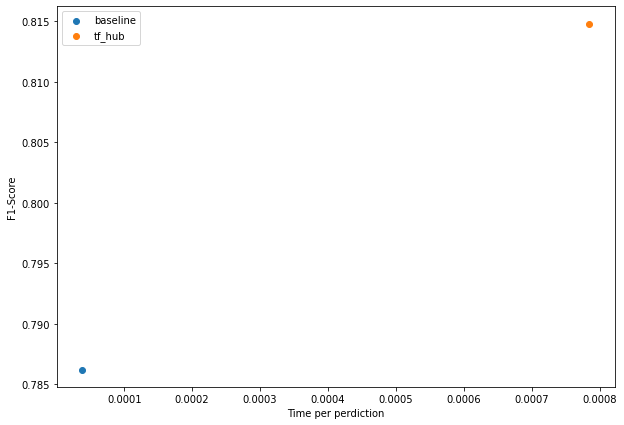

In [194]:
import matplotlib.pyplot as plt

plt.figure(figsize= (10,7))
plt.scatter(baseline_time_per_pred,baseline_results["f1"], label = "baseline")
plt.scatter(model_6_time_pre_pred, model_6_pretrained_results["f1"],label = "tf_hub")
plt.legend()
plt.xlabel("Time per perdiction")
plt.ylabel("F1-Score")